In [38]:
import pandas as pd
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import time

# 1. Data collection


In [39]:
df = pd.read_csv('result.csv', encoding = 'utf-8-sig')
df_transfer = pd.read_csv('player_transfer_values.csv', encoding = 'utf-8-sig')
df = df[df['Minutes'] > 900]
df_transfer['Player'] = df_transfer['Player'].replace('Igor Júlio', 'Igor')
df = pd.merge(df, df_transfer[['Player', 'Transfer Value']], how = 'left', on = ['Player']).dropna().reset_index(drop = True)
df = df.replace('N/a', pd.NaT)

# 2. Statistics  


In [40]:
print('Shape of data:', df.shape)

df.head(5)  

Shape of data: (303, 79)


,Player,Nation,Team,Position,Age,Matches Played,Starts,Minutes,Goals,Assists,...,Possession PrgR,Fls,Fld,Off,Crs,Recov,Won,Miscellaneous Stats Lost,Won%,Transfer Value
0,Aaron Ramsdale,ENG,Southampton,GK,26-357,27,27,2430,0,0,...,0,1,4,0,0,20,5,0,100.0,€18.7M
1,Aaron Wan-Bissaka,ENG,West Ham,DF,27-161,33,32,2884,2,3,...,150,22,25,4,70,163,22,30,42.3,€26.9M
2,Abdoulaye Doucouré,MLI,Everton,MF,32-125,30,29,2425,3,1,...,91,46,5,10,23,139,29,43,40.3,€5.8M
3,Adam Armstrong,ENG,Southampton,"FW,MF",28-085,20,15,1248,2,2,...,79,12,5,9,14,23,5,9,35.7,€15.1M
4,Adam Smith,ENG,Bournemouth,DF,34-007,22,17,1409,0,0,...,31,15,11,0,30,43,12,13,48.0,€1.5M


In [41]:
df.info()
# Most nul value feature: Penalty Kicks Save%, CS%, Save%, GA90, SoT%, G/sh, Dist, Succ%, Tkld%

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 79 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Player                     303 non-null    object 
 1   Nation                     303 non-null    object 
 2   Team                       303 non-null    object 
 3   Position                   303 non-null    object 
 4   Age                        303 non-null    object 
 5   Matches Played             303 non-null    int64  
 6   Starts                     303 non-null    int64  
 7   Minutes                    303 non-null    int64  
 8   Goals                      303 non-null    int64  
 9   Assists                    303 non-null    int64  
 10  Yellow Cards               303 non-null    int64  
 11  Red Cards                  303 non-null    int64  
 12  Expected Goals             303 non-null    float64
 13  Expedted Assist Goals      303 non-null    float64

In [42]:
obj = (df.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Total numbers of categorical features:", len(object_cols))
print(object_cols)

Total numbers of categorical features: 17
['Player', 'Nation', 'Team', 'Position', 'Age', 'GA90', 'Save%', 'CS%', 'Penalty Kicks Save%', 'SoT%', 'G/sh', 'Dist', 'Long Pass completion', 'Succ%', 'Tkld%', 'Won%', 'Transfer Value']


In [43]:
df.describe()

,Matches Played,Starts,Minutes,Goals,Assists,Yellow Cards,Red Cards,Expected Goals,Expedted Assist Goals,PrgC,...,Dis,Rec,Possession PrgR,Fls,Fld,Off,Crs,Recov,Won,Miscellaneous Stats Lost
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,...,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,27.514851,22.716172,2002.990099,2.960396,2.191419,4.148515,0.122112,2.931683,2.178218,37.686469,...,18.851485,794.957096,72.283828,22.006601,21.564356,3.402640,35.283828,84.326733,26.359736,25.828383
std,5.994391,7.620900,642.242731,4.198519,2.544243,2.619537,0.356964,3.657767,2.118209,34.309036,...,16.369322,372.145820,73.796337,14.087238,15.504592,4.700598,42.292955,42.575319,23.986046,19.987502
min,11.000000,8.000000,903.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,132.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000
25%,24.000000,16.000000,1461.000000,0.000000,0.000000,2.000000,0.000000,0.600000,0.550000,12.000000,...,5.000000,524.000000,8.500000,12.000000,10.000000,0.000000,4.000000,50.000000,9.000000,12.000000
50%,29.000000,23.000000,2034.000000,1.000000,1.000000,4.000000,0.000000,1.500000,1.500000,28.000000,...,16.000000,736.000000,54.000000,20.000000,18.000000,2.000000,15.000000,78.000000,19.000000,21.000000
75%,32.000000,29.000000,2518.500000,4.000000,3.000000,6.000000,0.000000,3.900000,3.100000,56.000000,...,28.500000,960.000000,108.500000,29.000000,30.000000,4.000000,55.000000,110.000000,37.000000,34.000000
max,35.000000,35.000000,3150.000000,28.000000,18.000000,12.000000,2.000000,24.000000,13.200000,189.000000,...,89.000000,2153.000000,440.000000,67.000000,100.000000,27.000000,191.000000,203.000000,134.000000,128.000000


In [44]:
null_percent = df.isnull().sum() / df.shape[0] * 100
null_percent_sorted = null_percent.sort_values(ascending=False)
null_percent_sorted

Penalty Kicks Save%         93.069307
GA90                        92.409241
CS%                         92.409241
Save%                       92.409241
Dist                         6.930693
                              ...    
Recov                        0.000000
Won                          0.000000
Miscellaneous Stats Lost     0.000000
Won%                         0.000000
Transfer Value               0.000000
Length: 79, dtype: float64

# 3. Data preprocessing 


In [45]:
# drop outliner
df = df[df['Player'] != 'Mohamed Salah']

# missing data
df = df.drop(columns = ['Player', 'GA90', 'Save%', 'CS%', 'Penalty Kicks Save%'])
columns_to_fill = ['Succ%', 'Tkld%', 'G/sh', 'Dist', 'SoT%']
for col in columns_to_fill:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].fillna(df[col].mean())

# convert age and transfer value
df['Age'] = df['Age'].apply(lambda x : float(f'{(int(x.split('-')[0]) + (int(x.split('-')[1]) / 365)):.2f}'))
df['Transfer Value'] = df['Transfer Value'].apply(lambda x : float(x[1:len(x) - 1:]))

df = df.astype({
    'Long Pass completion' : 'float',
    'Won%' : 'float'
})

# convert categorical to numerical feature
le_nation = LabelEncoder()
df['Nation'] = le_nation.fit_transform(df['Nation'])

le_team = LabelEncoder()
df['Team'] = le_team.fit_transform(df['Team'])

df = df.drop(columns = 'Position')

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 302 entries, 0 to 302
Data columns (total 73 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Nation                     302 non-null    int64  
 1   Team                       302 non-null    int64  
 2   Age                        302 non-null    float64
 3   Matches Played             302 non-null    int64  
 4   Starts                     302 non-null    int64  
 5   Minutes                    302 non-null    int64  
 6   Goals                      302 non-null    int64  
 7   Assists                    302 non-null    int64  
 8   Yellow Cards               302 non-null    int64  
 9   Red Cards                  302 non-null    int64  
 10  Expected Goals             302 non-null    float64
 11  Expedted Assist Goals      302 non-null    float64
 12  PrgC                       302 non-null    int64  
 13  PrgP                       302 non-null    int64  
 14 

# 4. Data visualization


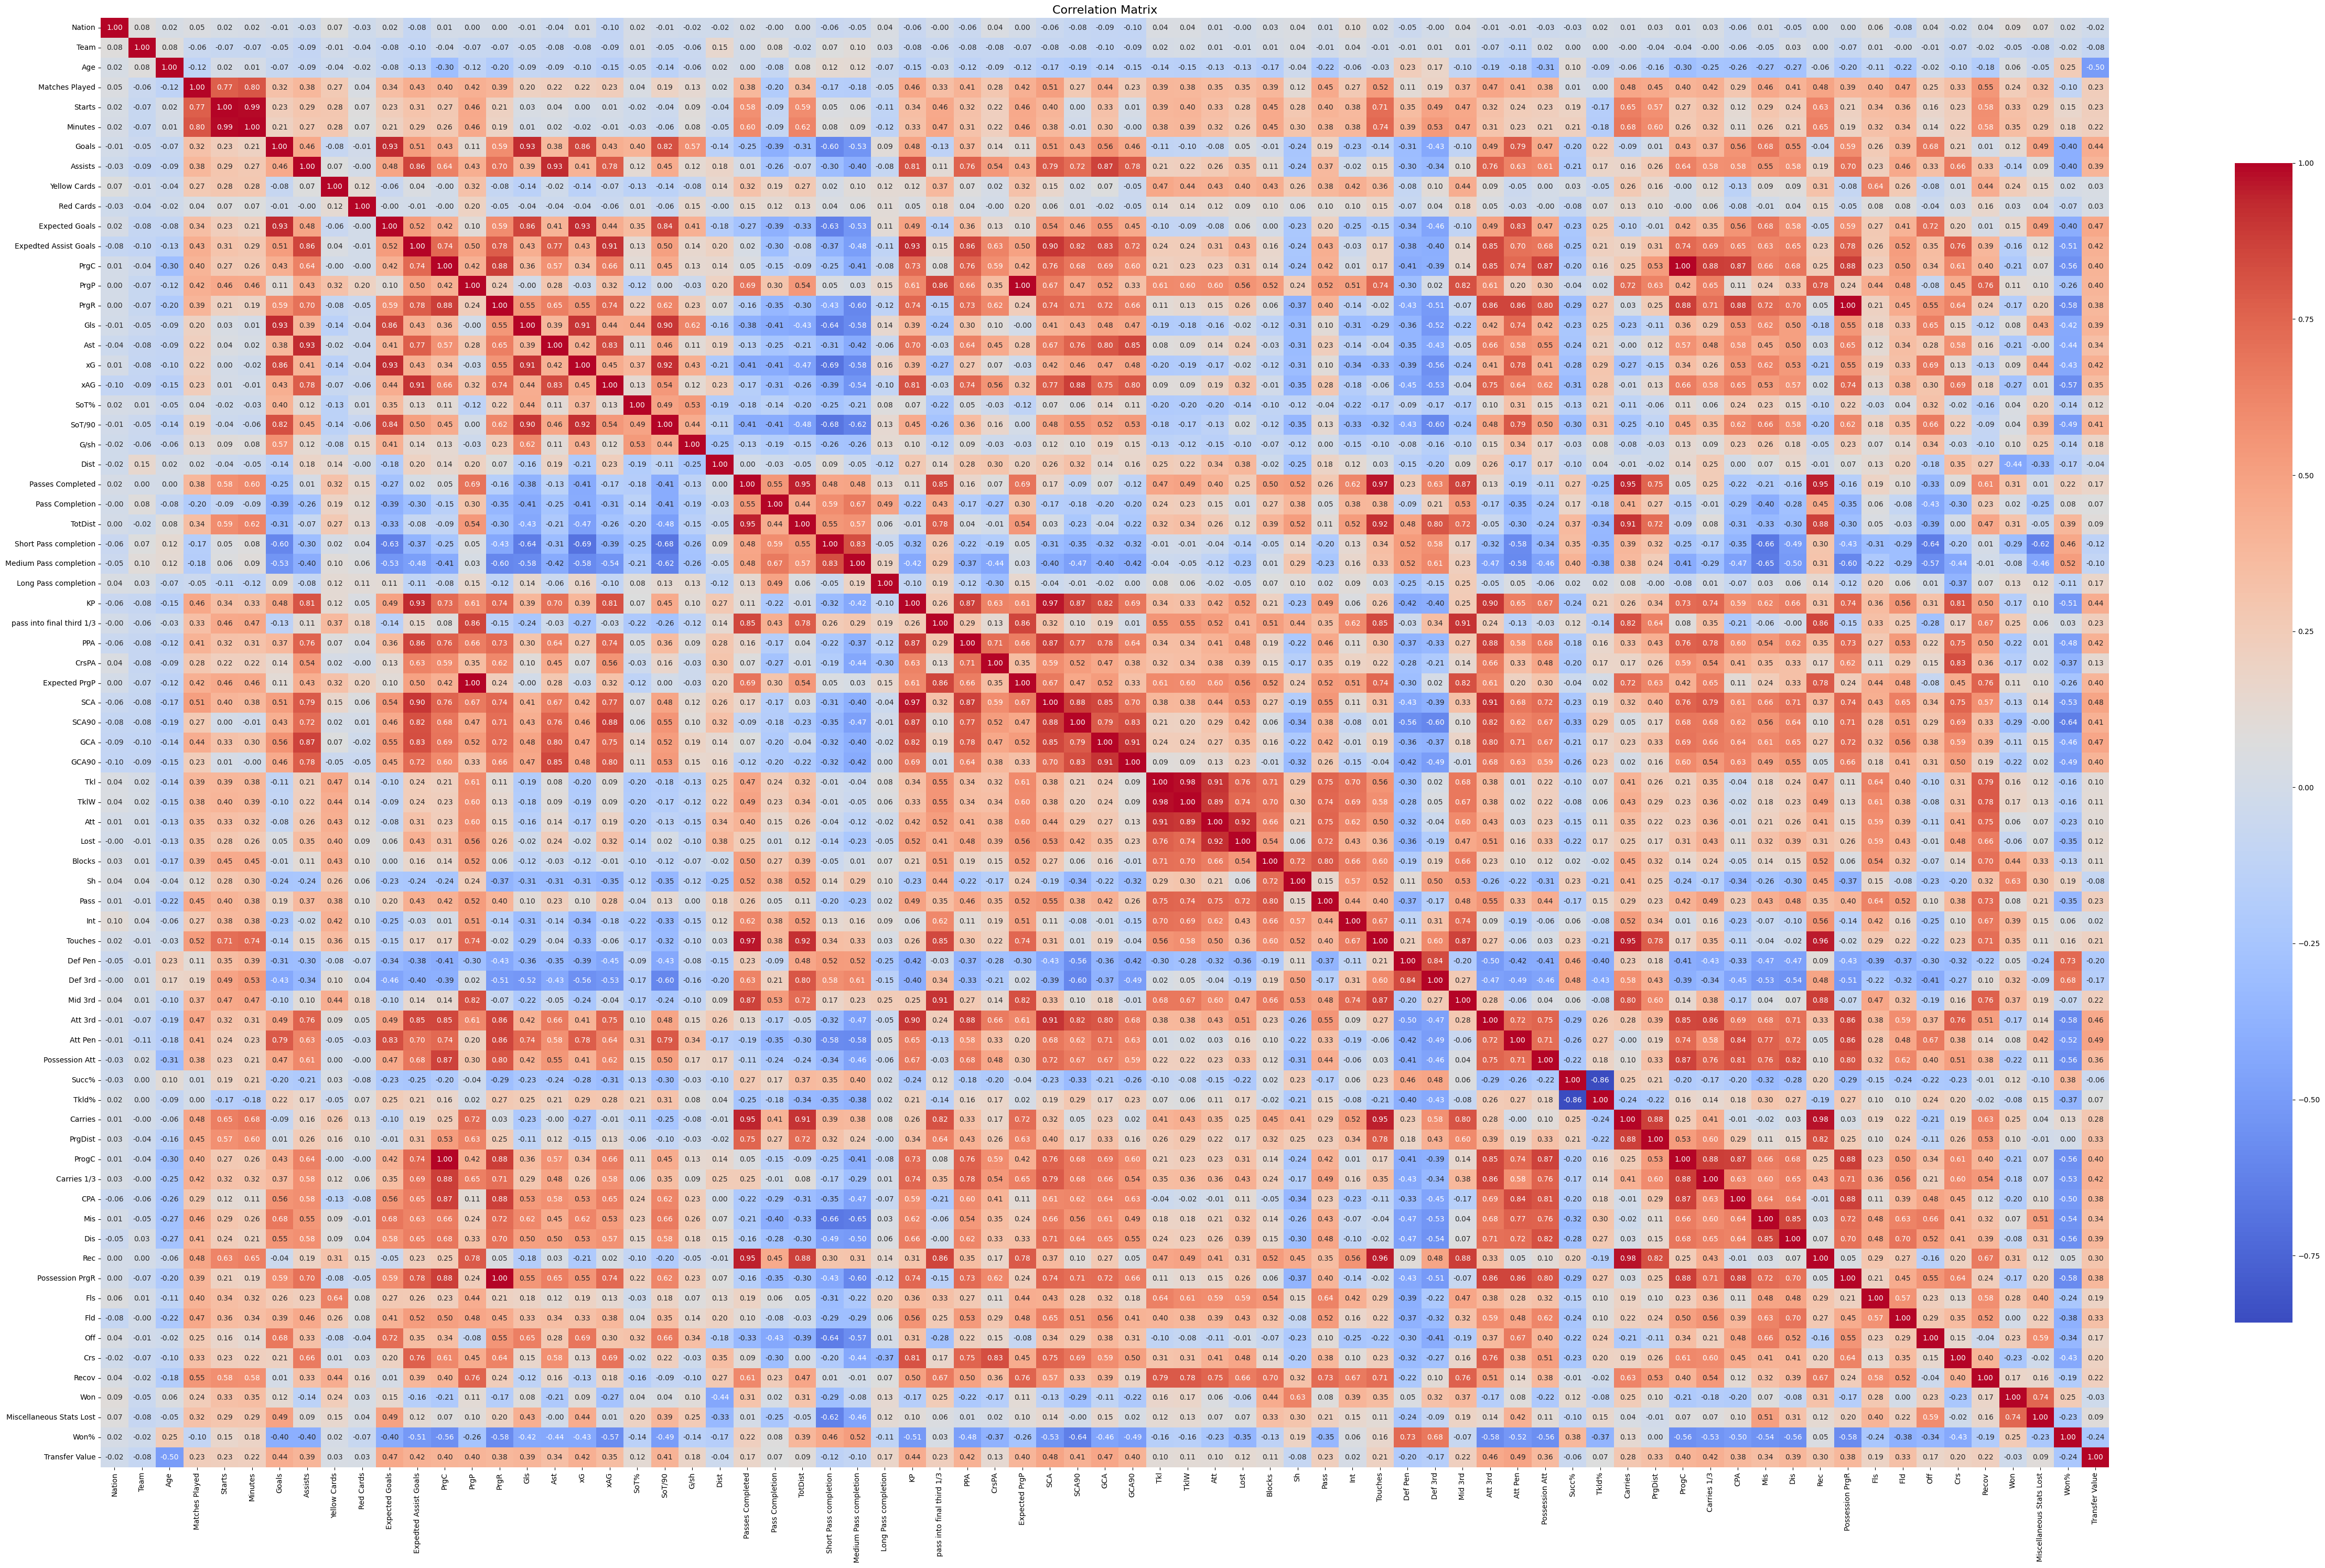

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix
corr_matrix = df.corr()

# Create the heatmap for visualization
plt.figure(figsize=(50, 30))  # Adjust the figure size for better layout
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size": 10}, cbar_kws={'shrink': 0.8})

# Add a title to the plot
plt.title("Correlation Matrix", fontsize=16)

# Adjust layout to prevent clipping
plt.tight_layout()

# Close the plot
plt.show()


# 5. Model building

5.1 Choose important features for train model


In [47]:
# get correlation between each feature and the target 'Transfer Value'
value_corr = corr_matrix['Transfer Value'].drop('Transfer Value')

# select features with a correlation coefficient > 0.2
selected_features = value_corr[abs(value_corr) > 0.2].sort_values(ascending=False)
print("Features strongly correlated with the Transfer Value:")
print(selected_features)

# create a subset of the DataFrame with the selected features
selected_df = df[selected_features.index]

# keep only the upper triangle (to avoid duplicate pairs)
upper_df = selected_df.corr().abs().where( np.triu(np.ones(selected_df.corr().abs().shape), k=1).astype(bool))

# drop highly correlated features (correlation > 0.9)
to_drop = [column for column in upper_df.columns if any(upper_df[column] > 0.9)]
print("Dropped due to high correlation:", to_drop)
selected_df = selected_df.drop(columns=to_drop)

# add the target column back for further analysis
selected_df['Transfer Value'] = df['Transfer Value']

# calculate the absolute correlation coefficients with the target again
cor_coef = selected_df.corr().abs()['Transfer Value'].drop('Transfer Value').sort_values(ascending=False)
print("Correlation Coefficient:\n", cor_coef, sep='')


Features strongly correlated with the Transfer Value:
Att Pen                      0.485797
SCA                          0.483373
GCA                          0.473495
Expected Goals               0.469662
Att 3rd                      0.456853
Goals                        0.437881
KP                           0.436005
Carries 1/3                  0.422645
xG                           0.421334
PPA                          0.417262
Expedted Assist Goals        0.415911
SCA90                        0.412901
SoT/90                       0.407723
ProgC                        0.402174
PrgC                         0.402174
GCA90                        0.399624
Expected PrgP                0.395208
PrgP                         0.395208
Gls                          0.394987
Assists                      0.392784
Dis                          0.389802
PrgR                         0.383270
Possession PrgR              0.383270
CPA                          0.378825
Possession Att               0.364

In [48]:
important_features = cor_coef.index.tolist()
print(important_features)

['Age', 'Att Pen', 'SCA', 'GCA', 'Expected Goals', 'Carries 1/3', 'PPA', 'SCA90', 'ProgC', 'Expected PrgP', 'Assists', 'Dis', 'PrgR', 'CPA', 'Possession Att', 'Mis', 'PrgDist', 'Fld', 'Rec', 'Won%', 'Matches Played', 'Starts', 'Pass', 'pass into final third 1/3', 'Recov', 'Def Pen']


5.2 Split data train and test

In [49]:
df = df[important_features + ['Transfer Value']]
X = df.drop(columns=['Transfer Value'])
y = df['Transfer Value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 241
Test set size: 61


5.3 Create model and train

In [50]:
models = [
    ('Linear Regression', LinearRegression()),
    ('Random Forest', RandomForestRegressor(random_state = 42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state = 42)),
    ('KNN', KNeighborsRegressor()),
    ('AdaBoost', AdaBoostRegressor(random_state = 42)),
    ('Decision Tree', DecisionTreeRegressor(random_state = 42))
]

results_list = []
for name, model in models:
    start_time = time.time()
    model.fit(X_train, y_train.values.ravel())
    end_time = time.time()
    train_time = end_time - start_time

    start_time = time.time()
    predictions = model.predict(X_test)
    end_time = time.time()
    prediction_time = end_time - start_time

    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)  
    model_results = {"Model": name,
                    "Train_Score": model.score(X_train, y_train),
                    "Test_Score": model.score(X_test, y_test),
                    "MSE": mse,
                    "RMSE": rmse,
                    "MAE": mae,
                    "Train Time": train_time,
                    "Prediction Time": prediction_time}
    results_list.append(model_results)
results = pd.DataFrame(results_list)
display(results.style.set_table_attributes("style='display:inline'").set_caption('Regression Results'))


,Model,Train_Score,Test_Score,MSE,RMSE,MAE,Train Time,Prediction Time
0,Linear Regression,0.601824,0.671365,213.567339,14.613943,11.982958,0.004132,0.002729
1,Random Forest,0.927359,0.668453,215.459810,14.678549,11.170443,0.423853,0.009208
2,Gradient Boosting,0.964298,0.678076,209.206594,14.463976,11.607361,0.206229,0.002292
3,KNN,0.373315,0.148918,553.086315,23.517787,19.521639,0.001637,0.005462
4,AdaBoost,0.703124,0.512386,316.881869,17.801176,15.462404,0.127099,0.014457
5,Decision Tree,1.000000,0.386703,398.558689,19.963935,14.619672,0.006970,0.001726


In [51]:
# based on Regression Results I think LinearRegression is best model
best_model = LinearRegression()
best_model.fit(X_train, y_train)

LinearRegression()

# 6. Model evaluation

In [52]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Train R²: {train_r2:.2f}")
print(f"Test R²: {test_r2:.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_scores)
print(f"Mean CV R²: {np.mean(cv_scores):.2f}")

Train R²: 0.60
Test R²: 0.67
MAE: 11.98
Cross-validated R² scores: [0.6290007  0.44727447 0.544364   0.45966905 0.41957632]
Mean CV R²: 0.50


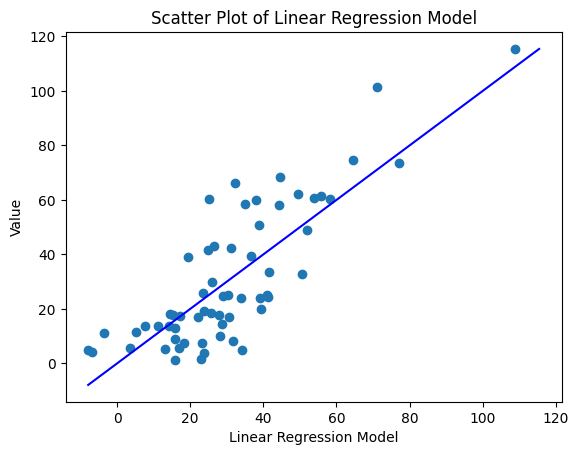

In [53]:
predictions = best_model.predict(X_test)

predictions = np.array(predictions).astype(float)
y_test = np.array(y_test).astype(float)

plt.scatter(predictions, y_test)
plt.xlabel("Linear Regression Model")
plt.ylabel("Value")
plt.title("Scatter Plot of Linear Regression Model")

min_value = min(min(predictions), min(y_test))
max_value = max(max(predictions), max(y_test))

x = np.linspace(min_value, max_value, 100)
y = x
plt.plot(x, y, color='blue', linestyle='solid')

plt.show()


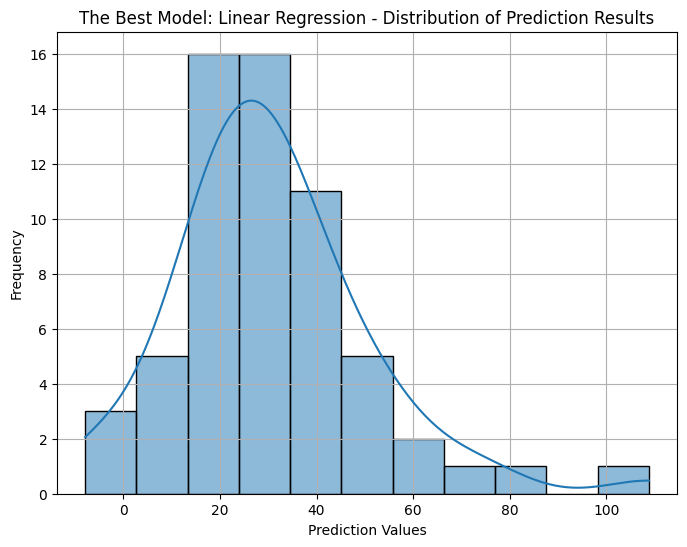

In [54]:
y_test_pred = best_model.predict(X_test)

plt.figure(figsize=(8, 6))
sns.histplot(data=y_test_pred, kde=True)
plt.xlabel('Prediction Values')
plt.ylabel('Frequency')
plt.title(f'The Best Model: Linear Regression - Distribution of Prediction Results')
plt.grid(True)

plt.show()
